### Combinatorial Cascading Bandits

Combinatorial Cascading BanditsはCascading Banditsの自然な拡張であり、ユーザーがリスト内の1つのアイテムしかクリックしないという強い仮定を起きません。

選択したすべてのアイテムの重み$w$が1である場合にのみ、エージェントは1の報酬を受け取ります。つまり報酬関数は以下のように定義できます。

$$
f(A,w) = \prod_{e \in A} w(e) \\
w \in [0, 1]^E
$$

この関数からCombinatorial Cascading Banditsでは全てのアイテムがクリックされる確率を最大化するように学習することがわかります。

Combinatorial Cascading Banditsの具体的な実装としてKvetonらによって提案されている**CombCascade**[3]はUCBベースのアルゴリズムであり、UCBを以下のように計算します。

$$
U_t(e) = \min{(\hat{w}_{T_{t−1}(e)}(e) + c_{t−1,T_{t−1}(e)},1)}
$$

CombCascadeは、$A_t$の中で重みがゼロの最初のアイテムのインデックス$O_t$を観測して$k≤O_t$となるすべてのアイテム$a^{t}_k$について、重みの推定値を更新します。

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import bernoulli

In [2]:
np.random.seed(0)

In [3]:
class MultiClicksModelEnv():
	def __init__(self, E: list[float]):
		self.E = E

	def clicks(self, A: list[int]) -> list[int]:
		clicks = []
		for i, item in enumerate(A):
			if self.E[item] > np.random.random():
				clicks.append(i+1)
		return clicks
	
	def opt(self, k: int) -> list[int]:
		return sorted(range(len(self.E)), key=lambda i: self.E[i], reverse=True)[:k]

In [4]:
class CombCascadeAgent():
  def __init__(self, E: list[float], p: float):
    self.t = 1
    self.counts = [1 for _ in range(len(E))]
    self.weights = [bernoulli.rvs(p=p) for _ in range(len(E))]

  def ucb(self, e: int) -> float:
    return min(self.weights[e] + math.sqrt(1.5*math.log(self.t - 1)/self.counts[e]), 1)

  def get_list(self, k: int) -> list[int]:
    self.t += 1
    ucbs = [self.ucb(e) for e in range(len(E))]
    return sorted(range(len(ucbs)), key=lambda i: ucbs[i], reverse=True)[:k]

  def before_no_click(self, no_click: int, k: int) -> int:
    return 1 if k < no_click else 0

  def observe(self, a: list[int], no_click_feedback : int) -> None:
    if no_click_feedback == -1:
      no_click_feedback = len(a)

    for i in range(min(len(a), no_click_feedback)):
      e = a[i]
      before_count = self.counts[e]
      self.counts[e] += 1
      self.weights[e] = ( (before_count * self.weights[e]) + self.before_no_click(no_click_feedback, i+1) ) / self.counts[e]

In [5]:
def first_no_click(a: list[int], clicks: list[int]) -> int:
	if clicks == []:
		return 1

	for i in range(1, len(a)+1):
		try:
			c = clicks[i-1]
		except IndexError:
			return i
		if c == i:
			continue
		return i
	return -1

# debug
print(first_no_click([4,3,5], [1, 3]))
print(first_no_click([4,3,5], [1, 2]))
print(first_no_click([4,3,5], [2]))

2
3
1


In [6]:
def f_comb(weights: list[float]) -> float:
	v = 1
	for w in weights:
		v *= w
	return v

def regret_comb(optimal_weights: list[float], weights: list[float]) -> float:
	return f_comb(optimal_weights) - f_comb(weights)

optional list: [0, 2, 5]
[0, 3, 2]


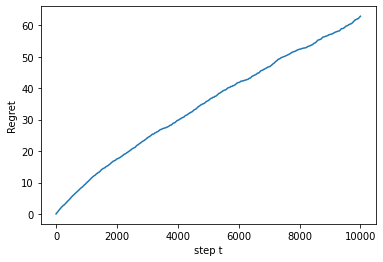

In [7]:
k=3
E = [0.3, 0.2, 0.25, 0.1, 0.1, 0.24, 0.2, 0.1, 0.21, 0.1]
env = MultiClicksModelEnv(E=E)

optimal = env.opt(k=k)
optimal_weights = sorted(E, reverse=True)[:k]

print(f'optional list: {optimal}')

agent = CombCascadeAgent(E=E, p=0.2)

cumulative_regret = 0
regret_cumulative_history = []
for i in range(10000):
	a = agent.get_list(k=k)
	clicks = env.clicks(a)
	no_click_feedback = first_no_click(a, clicks)
	agent.observe(a, no_click_feedback)

	setting_weights = [E[i] for i in a]
	cumulative_regret += regret_comb(optimal_weights, setting_weights)
	regret_cumulative_history.append(cumulative_regret)

print(agent.get_list(k=k))
plt.xlabel("step t")
plt.ylabel("Regret")
plt.plot(regret_cumulative_history)